# Demo 4: Monitor class disentanglement
h-NNE generates a representation which follows some of the clustering properties of the data in the initial space. This allows for a simple qualitative evaluation of feature spaces.
In this notebook, we pass the CIFAR-10 dataset through a ResNet18 network and extract all the intermediate outputs of the main blocks.\
When embedded to 2D with h-NNE, one can visualize the gradual disentanglement that occurs while going deeper through the network.

In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
import torch

from hnne import HNNE

## Getting the CIFAR-10 pre-trained networks and the repo with the model definitions
The models used for the experiment come from the following repository: https://github.com/huyvnphan/PyTorch_CIFAR10.\
The repository contains a collection of common networks availably in torchvision which are adapted and trained on CIFAR-10.\
You can use the command below to clone the repository. Then you need to download the models from the link to Google Drive provided in the repository and expand and copy them to 'PyTorch_CIFAR10/cifar10_models/'.


In [ ]:
!git clone git@github.com:huyvnphan/PyTorch_CIFAR10.git

In [2]:
from PyTorch_CIFAR10.cifar10_models import resnet

## Load the ResNet18 network and CIFAR-10
In case no gpu is available, one can set the devive name to cpu. The inference will take much longer, so one can also subsample the dataset to run the notebook quickly.

In [8]:
device = torch.device('cuda:0')
resnet_cifar = resnet.resnet18(pretrained=True)
resnet_cifar.to(device)
resnet_cifar.eval()

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2471, 0.2435, 0.2616))
])

layers = list(resnet_cifar.children())
initial_conv = torch.nn.Sequential(*layers[:4])
intermediate_blocks = layers[4:8]

In [6]:
cifar10_train = CIFAR10(root='.', download=True, train=True)
cifar10_test = CIFAR10(root='.', download=True, train=True)

Files already downloaded and verified
Files already downloaded and verified


## Extract values of all intermediate blocks

In [ ]:
intermediate_outputs = [[], [], [], [], []]

for img, label in tqdm(cifar10_train):
    with torch.no_grad():
        img = transform(img).unsqueeze(0).to(device)
        output = initial_conv(img)
        intermediate_outputs[0].append(output)
        for i, block in enumerate(intermediate_blocks, start=1):
            output = block(output)
            intermediate_outputs[i].append(output.cpu().detach().numpy())
        
for i in range(len(intermediate_outputs)):
    intermediate_outputs[i] = np.vstack(intermediate_outputs[i]).reshape((len(cifar10_train), -1))

## Project the data and all intermediate outputs with h-NNE

In [13]:
%%time
hnne = HNNE()
projection_data = hnne.fit_transform(cifar10_train.data.reshape(-1, 32*32*3))

/home/mkoulakis/.pyenv/versions/3.7.10/envs/pytorch-3.7/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 3min 22s, sys: 57.9 s, total: 4min 20s
Wall time: 26.7 s


In [14]:
%%time
intermediate_projections = [[], [], [], [], []]
for i in tqdm(list(range(len(intermediate_outputs)))):
    intermediate_projections[i] = HNNE().fit_transform(intermediate_outputs[i])

CPU times: user 34min 40s, sys: 11min 20s, total: 46min
Wall time: 6min 39s


## Plot the embeddings
One can observe how the separation of targets in different clusters reflects the increasing quality of the features as one goes deeper through the network.

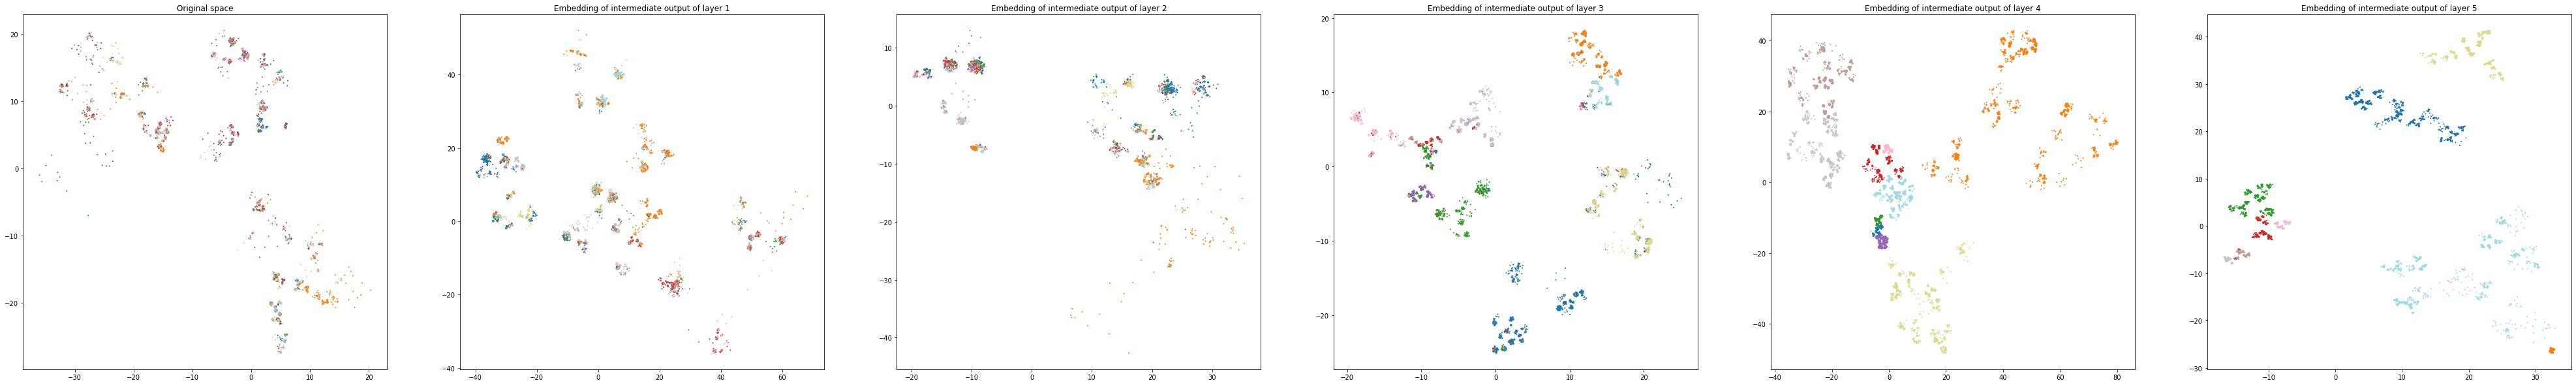

In [15]:
_, ax = plt.subplots(1, 6, figsize=(10*(6 + 1), 10))

ax[0].set_title('Original space')
ax[0].scatter(*projection_data.T, s=1, c=cifar10_train.targets, cmap='tab20')

for i, intermediate in enumerate(intermediate_projections, start=1):
    ax[i].set_title(f'Embedding of intermediate output of layer {i}')
    ax[i].scatter(*intermediate.T, s=1, c=cifar10_train.targets, cmap='tab20')
plt.show()